In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Pauli, pauli_basis, SuperOp, PTM, Operator
from qiskit.circuit.library import CXGate, CZGate, HGate, SGate, SdgGate
from random import choice, choices
from itertools import product, permutations, cycle
from scipy.optimize import curve_fit, nnls
from matplotlib import pyplot as plt
import numpy as np
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo

In [2]:
from typing import List, Tuple, Dict
from qiskit.providers.backend import Backend, BackendV1, BackendV2
QUBIT = int
DOUBLE_GATE = 2
SINGLE_GATE = 1
NUM_BASES = 9

class NoiseLearningExperiment:
    #Base class which carries out functions such as generating the connectivity of the 
    #processor, creating the list of pauli measurement bases, and creating a dictionary
    #of pre-transpiled gates, and creating a dictionary of rules for commuting pauli
    #operators through Clifford operators
    def __init__(
        self,
        layer : List[QUBIT], #qubits nontrivially affected by layer
        backend : Backend, #desired backend
        start_vertex = 0 #this should be chosen to be an outside qubit
        ):

        #initialize variables
        self.layer = layer
        self.n = len(layer)
        self.backend = backend

        #Get properties from BackendV1 or BackendV2 object
        try:
            if isinstance(backend, BackendV1):
                proc_coupling = backend.configuration().coupling_map
                self.num_qubits = backend.configuration().num_qubits
            elif isinstance(backend, BackendV2):
                proc_coupling = backend.coupling_map
                self.num_qubits = backend.num_qubits
        except:
            raise Exception("There was an issue with the backend. Are you using a simulator?")

        if any([0 > q or q >= self.num_qubits for q in layer]):
            raise Exception("The layer is not compatible with the backend")

        #reduce coupling map to subset containing qubits in layer
        self.coupling_map = [
                                (q1, q2) for q1,q2 in proc_coupling 
                                if q1 in layer and q2 in layer
                            ]

        #generate adjacency matrix, pauli strings, and transpilation dictionaries for later use
        self.adjacency_matrix = self.get_connectivity()
        self.pauli_strings = self.get_pauli_strings(start_vertex)
        self.raw_gates = {}
        self.transpiled_gates = {} 
        self.raw_gates, self.transpiled_gates = self.generate_gate_dict()
        self.conjugate_gates = self.generate_conjugate_gates()
        self.model_paulis = self.get_benchmark_paulis()

    #parse coupling map to generate adjacency matrix
    def get_connectivity(self) -> List[List[int]]:
        qubits = self.layer
        n = self.n
        unmap = lambda i: self.layer.index(i)

        #remap qubits so that layer is sequential
        verts = [unmap(qubit) for qubit in qubits]
        edges = [
                    (unmap(qubit1), unmap(qubit2)) 
                    for qubit1,qubit2 in self.coupling_map
                ]

        #adjacency matrix has a 1 at i,j if i and j are connected, 0 otherwise
        adjacency_matrix = [[0 for i in verts] for j in verts] 
        for (vert1,vert2) in edges:
            adjacency_matrix[vert1][vert2] = 1
            adjacency_matrix[vert2][vert1] = 1

        return adjacency_matrix

    #Initiate the sweeping procedure to find all nine pauli bases. If set of layer qubits
    #is connected, then the recursive method bottoms out and this one starts it back up
    def get_pauli_strings(self, start_vertex) -> List[str]:
        verts = range(self.n)
        pauli_strings = [['I']*self.n for i in range(NUM_BASES)]
        adjacency_matrix = self.adjacency_matrix
        visited_verts = [] #keep track of veritices for which the bases are already selected
        remaining_verts = list(verts) 

        #decide basis ops for vertex based on bases chosen for any predecessors
        def getstr(vertex) -> None:
            
            #copied from Fig. S3 in van den Berg
            example_orderings = {"XXXYYYZZZ":"XYZXYZXYZ",
                                "XXXYYZZZY":"XYZXYZXYZ",
                                "XXYYYZZZX":"XYZXYZXYZ",
                                "XXZYYZXYZ":"XYZXZYZYX",
                                "XYZXYZXYZ":"XYZZXYYZX"}

            visited_verts.append(vertex)
            children = [i for i,e in enumerate(adjacency_matrix[vertex]) if e == 1]
            predecessors = [c for c in children if c in visited_verts]

            match len(predecessors):
                #trivial if no predecessors
                case 0:
                    cycp = cycle("XYZ")
                    for i,s in enumerate(pauli_strings):
                        pauli_strings[i][vertex] = next(cycp)

                #Choose p1:"XXXYYYZZZ" and p2:"XYZXYZXYZ" if one predecessor
                case 1:
                    predecessor = predecessors[0]

                    #store permutation of indices so that predecessor has X,X,X,Y,Y,Y,Z,Z,Z
                    reorder_list = [[] for i in range(3)]
                    for i in range(9):
                        basis = pauli_strings[i][predecessor]
                        reorder_list["XYZ".index(basis)].append(i)
                    
                    for i in range(3):
                        for j,c in enumerate("XYZ"):
                            idx = reorder_list[i][j]
                            pauli_strings[idx][vertex] = c

                case 2:
                    predecessor0 = predecessors[0]
                    predecessor1 = predecessors[1]

                    #use the same reordering trick to get XXXYYYZZZ on first predecessor
                    reorder_list = [[] for i in range(3)] 
                    for i in range(9):
                        basis = pauli_strings[i][predecessor0]
                        reorder_list["XYZ".index(basis)].append(i)
                    
                    #list out string with permuted values of predecessor 2
                    substring = ""
                    for list in reorder_list:
                        for idx in list:
                            substring += pauli_strings[idx][predecessor1]

                    #match predecessor two with a permutation of example_orderings
                    reordering = ""
                    for perm in permutations("XYZ"):
                        p_string = "".join(["XYZ"[perm.index(p)] for p in substring])
                        if p_string in example_orderings:
                            reordering = example_orderings[p_string]
                            break
                    
                    #unpermute the example orderings so that they match the original strings
                    i = 0
                    for list in reorder_list:
                        for idx in list:
                            pauli_strings[idx][vertex] = reordering[i]
                            i += 1

                case _: #processor needs to have connectivity so that there are <= 2 predecessors
                    raise Exception("Three or more predecessors encountered")
            
            for c in children: #call recursive method on children
                if c not in predecessors:
                    getstr(c)
            
        #run while there are remaining vertices
        while remaining_verts: 
            getstr(remaining_verts[0]) 
            remaining_verts = [v for v in verts if v not in visited_verts]

        pauli_strings = [Pauli("".join(string[::-1])) for string in pauli_strings]

        return pauli_strings

    def generate_gate_dict(self) -> Tuple[Dict, Dict]:
        transpiled_gates = {}
        raw_gates = {}
        backend = self.backend

        #transpile single pauli gates
        for p in pauli_basis(1, pauli_list = True):
            qc = QuantumCircuit(1)
            qc.append(p, [0])
            transpiled_gates[p.to_label()] = transpile(qc, basis_gates = backend._basis_gates())
            raw_gates[p.to_label()] = qc

        #transpile basis change gates composed with twirl gates
        for h,p in product(["H","HS", "SdgH", "S", "Sdg"],["I","X","Y","Z",""]):
            qc = QuantumCircuit(1)
            match h:
                case "H":
                    qc.h(0)
                case "HS":
                    qc.h(0)
                    qc.s(0)
                case "SdgH":
                    qc.sdg(0)
                    qc.h(0)
                case "S":
                    qc.s(0)
                case "Sdg":
                    qc.sdg(0)

            if p:
                qc.append(Pauli(p),[0])

            transpiled_gates[h+p] = transpile(qc, basis_gates = backend._basis_gates())
            raw_gates[h+p] = qc

        transpiled_gates['I'].id(0)
        transpiled_gates['Z'].id(0)

        return raw_gates, transpiled_gates

    #generate the list of paulis for the sparse model based on connectivity
    def get_benchmark_paulis(self):
        n = len(self.adjacency_matrix)
        pauli_list = []
        idPauli = Pauli("I"*n)    
    
        #get all single-weight paulis
        for i in range(n):
            for op in pauli_basis(1, pauli_list = True):
                pauli = idPauli.copy()
                pauli[i] = op
                pauli_list.append(pauli)
                
        #get all weight-two paulis on with suport on nieghboring qubits
        for vert1,link in enumerate(self.adjacency_matrix):
            for vert2,val in enumerate(link[:vert1]):
                if val == 1:
                    for pauli1, pauli2 in pauli_basis(2, pauli_list = True):
                        pauli = idPauli.copy()
                        pauli[vert1] = pauli1
                        pauli[vert2] = pauli2
                        pauli_list.append(pauli)

        return pauli_list

    def print_gate_conversions(self) -> QuantumCircuit:
        raw_gates = self.raw_gates
        transpiled_gates = self.transpiled_gates

        qc = QuantumCircuit(len(raw_gates))
        for i,p in enumerate(raw_gates.keys()):
            qc = qc.compose(raw_gates[p], [i])


            qc2 = QuantumCircuit(len(transpiled_gates))

        for i,p in enumerate(transpiled_gates.keys()):
            qc2 = qc2.compose(transpiled_gates[p], [i])

        qc.barrier()
        qc = qc.compose(qc2)
        return qc

In [76]:
from typing import NewType, Tuple

TwoQubitGate = NewType("TwoQubitGate", Tuple[str, Tuple[int]])

class TwoQubitGateLayerExperiment(NoiseLearningExperiment):

    #This class generates the circuits and corresponding metadata to measure the noise
    #through a layer of cx or cz gates with context qubits
    def __init__(
        self, 
        layer : List[QUBIT], 
        backend : Backend, 
        two_qubit_gates : List[TwoQubitGate], 
        context_qubits=[], 
        samples=64, 
        depths = [2,4,8,16,32,64,128], 
        start_vertex = 0
        ):

        #generate all of the processor information from parent class
        super().__init__(layer, backend, start_vertex)

        #initialize variables
        self.two_qubit_gates = two_qubit_gates
        self.context_qubits = context_qubits
        self.samples = samples
        self.depths = depths

        #get clifford commutation rules and chategorize model paulis
        self.conjugate_gates = TwoQubitGateLayerExperiment.generate_conjugate_gates()
        self.pauli_sets = self.get_pauli_sets()

    
    #generate a dictionary of rules for how paulis conjugate through gates
    @staticmethod
    def generate_conjugate_gates() -> Dict[str, Dict[Pauli, Pauli]]:
        pauli_group = pauli_basis(2, pauli_list = True)
        #remove the phase from a Pauli
        def without_phase(pauli):
            return Pauli((pauli.z, pauli.x))

        #conjugate a pauli with a clifford
        def conjugate(p, c):
            return without_phase(Pauli(get_name(c @ p.to_matrix() @ np.conjugate(np.transpose(c)))))

        #given a pauli matrix, get the corresponding name (in terms of I,X,Y,Z)
        def get_name(pauli):
            for p in pauli_group:
                if Operator(p).equiv(Operator(pauli)):
                    return p

        #dictionary where keys are clifford gates
        gates_dict = {'cx':{}, 'cz':{}, 'H':{}, 'S':{}, 'Sdg':{}, 'SdgH':{}, 'HS':{}}

        #define rules for cx, cz gates
        two_qubit_gates = [('cx',CXGate()), ('cz', CZGate())]

        for p,(g_name, g) in product(pauli_group, two_qubit_gates):
            gates_dict[g_name][p] = conjugate(p, g.to_matrix())
        
        #repeat for single-qubit H,S,HS,SdgH gates
        pauli_group = pauli_basis(1, pauli_list = True)
        single_qubit_gates = [("H", HGate().to_matrix()), ("S", SGate().to_matrix()),
                                ("Sdg", SdgGate().to_matrix()),
                                ("HS", SGate().to_matrix() @ HGate().to_matrix()),
                                ("SdgH", HGate().to_matrix() @ SdgGate().to_matrix())]

        for p,(g_name, g_mat) in product(pauli_group, single_qubit_gates):
            gates_dict[g_name][p] = conjugate(p,g_mat)

        return gates_dict

    #find the affect of conjugating each of the benchmark paulis through a gate layer
    def get_pauli_pairs(self) -> List[Tuple[Pauli, Pauli]]:
        benchmark_paulis = self.model_paulis
        conjugate_paulis = []

        for pauli in benchmark_paulis:
            #the context qubits have no affect on the operator
            total = Pauli("I"*self.n)
            for qubit in self.context_qubits:
                idx = self.layer.index(qubit)
                total[idx] = pauli[idx]

            #add the affect of conjugation by each two-qubit gate to total
            for gate,support in self.two_qubit_gates:
                #reindex
                (q1,q2) = tuple(self.layer.index(s) for s in support)
                #get subset of pauli acting on support of gate
                op = pauli[q2].tensor(pauli[q1])
                conjugate = self.conjugate_gates[gate][op].copy()
                #add this to the total
                for q,conj in zip([q1,q2],conjugate):
                    total[q] = conj
            conjugate_paulis.append(total)

        #return pairs
        return list(zip(benchmark_paulis, conjugate_paulis))

    #sort paulis into easy, medium and hard sets
    # - easy set is conjugate to itself and can be measured directly
    # - medium set are pairs that can be measured through insertion of single-qubit gates
    #   without changing rank of matrix
    # - hard set requires single, SPAM-sensitive measurements to be completed
    def get_pauli_sets(self) -> Dict[str, List[Pauli]]:
        pairs = self.get_pauli_pairs()

        def weight(pauli):
            label = pauli.to_label()
            return len(label) - label.count("I")

        easy = [(p1,p2) for p1,p2 in pairs if p1 == p2 or weight(p2) > 2]
        medium = [(p1,p2) for p1,p2 in pairs if weight(p1) == weight(p2) and p1 != p2] 
        hard = [(p1,p2) for p1, p2 in pairs if weight(p1) == 1 and weight(p2) == 2]
    
        return {"easy":easy,"medium":medium,"hard":hard}

    # generate a single instance of a measurement circuit sampled from the twirl,
    #initializing in prep_basis, measuring in meas_basis, with noise_repetitions
    #single-layer cycles (in addition to readout noise), combined with gates to control
    #pauli_pairs, and transpiled for the backend target
    def generate_double_instance(self, 
        prep_basis : Pauli, 
        meas_basis : Pauli, 
        noise_repetitions : int, 
        basis_change_gates=None, 
        transpiled=True) -> Tuple[QuantumCircuit, Dict]:

        n = self.n
        #argument checking
        if len(prep_basis) != n or len(meas_basis) != n:
            raise Exception("Prep/measurement bases must be full rank")

        two_qubit_gates = self.two_qubit_gates
        context_qubits = self.context_qubits
        circ = QuantumCircuit(np.max(self.layer)+1) #storing the final circuit

        #choose transpiled representation of the gates for readability
        if transpiled:
            gate_dict = self.transpiled_gates
        else: 
            gate_dict = self.raw_gates

        #take hardware qubit indices to layer indices
        def unmap(i):
            return self.layer.index(i)

        #commute pauli through clifford gate
        def commute(gate : TwoQubitGate, pauli : Pauli):
            if gate == "":
                return pauli
            else:
                return self.conjugate_gates[gate][pauli].copy()

        #remove phase from pauli
        def without_phase(pauli : Pauli):
            return Pauli((pauli.z, pauli.x))

       #get preparation ops from desired basis 
        def prep(pauli_basis : Pauli):
            if pauli_basis.equiv(Pauli("X")):
                return "H"
            elif pauli_basis.equiv(Pauli("Y")):
                return "HS"
            else:
                return ""

        #apply operators to a quantum circuit to measure in desired pauli basis
        def meas(pauli_basis : Pauli, qubit : QUBIT, qc):
            if pauli_basis.equiv(Pauli("X")):
                qc.h(qubit)
            elif pauli_basis.equiv(Pauli("Y")):
                qc.sdg(qubit)
                qc.h(qubit)

        #apply a two-qubit gate to the circuit
        def apply(two_qubit_gate : TwoQubitGate, qc):
            gate,support = two_qubit_gate
            if gate == 'cx':
                qc.cx(*support)
            if gate == 'cz':
                qc.cz(*support)

        #get remapped index of desired basis-change gate to insert during benchmarking 
        def basis_change(i):
            return basis_change_gates[::-1][unmap(i)]

        #pick the first set of twirling operators
        first_twirl = choices(pauli_basis(1, pauli_list = True), k=n)

        #apply the prep and twirling operators to the circuit
        for qubit,p,b in zip(self.layer, first_twirl, prep_basis):
            gate_name = prep(b)
            gate_name += p.to_label()
            circ = circ.compose(gate_dict[gate_name], [qubit])

        #if no noise, don't apply the two-qubit gates on the first layer
        if noise_repetitions > 0:
            for gate,support in two_qubit_gates:
                apply((gate,support), circ)

        circ.barrier()

        #decompose twirl based on whether it lies on the context qubits or the support of
        #the multi-qubit gates
        two_qubit_final_ops = [
                                first_twirl[unmap(s2)].tensor(first_twirl[unmap(s1)]) 
                                for g,(s1,s2) in two_qubit_gates
                              ]
        context_qubit_final_ops = [first_twirl[qubit] for qubit in context_qubits]
    
        #apply repetitions of noise, including basis-change gates when needed
        for i in range(noise_repetitions-1):

            #apply for each two-qubit gate in layer
            for j,(op,(gate,support)) in enumerate(zip(two_qubit_final_ops,two_qubit_gates)):
                #get basis change gates on support of two-qubit gate
                s_gates = [basis_change(s) for s in support]
                twirl = choice(pauli_basis(DOUBLE_GATE, pauli_list = True))

                #compute pauli frame through gate from last layer
                op = commute(gate, op)
                #compute pauli frame through basis change gates
                for i,(b,pauli) in enumerate(zip(s_gates, op)):
                    op[i] = commute(b, pauli)
                #compose operator with next layer of twirl
                op = without_phase(op.compose(twirl))
                
                #store updated pauli frame
                two_qubit_final_ops[j] = op

                #apply basis change and twirl gates
                for qubit,s,t in zip(support, s_gates,twirl): 
                    gate_name = s
                    gate_name += t.to_label()
                    circ = circ.compose(gate_dict[gate_name],[qubit])

                #apply two-qubit gate 
                apply((gate,support),circ)

            #apply for context qubits
            for j,(op,qubit) in enumerate(zip(context_qubit_final_ops, context_qubits)):
                twirl = choice(pauli_basis(SINGLE_GATE, pauli_list = True))
                op = without_phase(op.compose(twirl))
                circ = circ.compose(gate_dict[twirl.to_label()], [qubit])
                #store updated pauli frame
                context_qubit_final_ops[j] = op

            circ.barrier()

        #choose sstring of bit flips for readout twirling
        rostring = "".join(choices(['I','X'], k=n))

        #the noise on the last layer corresponds only to readout noise, so the last layer
        #can be transpiled directly. First, it is stored in this circuit.
        qc = QuantumCircuit(np.max(self.layer)+1)

        #compute and apply final layer for all two-qubit gates
        for op,(gate,support) in zip(two_qubit_final_ops, two_qubit_gates):
            #update pauli frame through last layer of two-qubit gates
            op = commute(gate,op)
            #apply final gates
            for pauli,qubit in zip(op, support):
                #get basis change gate and update pauli frame
                s = basis_change(qubit)
                pauli = commute(s,pauli)
                if s and noise_repetitions > 0: #if there is a basis change gate, apply to circuit
                    qc = qc.compose(gate_dict[s], [qubit])
                qc.append(pauli, [qubit]) #apply final pauli to undo twirling
                #apply gates to switch to desired measurement basis
                b = meas_basis[unmap(qubit)]
                meas(b, qubit, qc)
                #apply readout twirling in little-endian order
                if rostring[::-1][unmap(qubit)] == "X":
                    qc.x(qubit)

        #compute and apply final layer for all context qubits
        for op,qubit in zip(context_qubit_final_ops, context_qubits):
            #undo twirl
            qc.append(op, [qubit])
            #switch to measurement basis
            b = meas_basis[unmap(qubit)]
            meas(b, qubit, qc)
            #apply readout twirling
            if rostring[::-1][unmap(qubit)] == "X":
                qc.x(qubit)

        if transpiled:
            qc = transpile(qc, basis_gates = self.backend._basis_gates(), optimization_level = 1)

        #add last layer to final circuit
        circ = circ.compose(qc)

        return circ, {
            "prep_basis":prep_basis,
             "meas_basis":meas_basis, 
             "length":noise_repetitions, 
             "rostring":rostring,
             "basis_change":basis_change_gates
             }

    def generate_measurement_circuits(self):
        bases = self.pauli_strings
        n = self.n
        depths = self.depths
        samples = self.samples
        easy = self.pauli_sets['easy']
        medium = self.pauli_sets['medium']
        hard = self.pauli_sets['hard']
        circuits = []
        metadatas = []

        basis_change = {
            ("X","Y") : "Sdg",
            ("Y","X") : "S",
            ("X","Z") : "H",
            ("Z","X") : "H",
            ("Z","Y") : "SdgH",
            ("Y","Z") : "HS",
        } 

        #make measurements in all the bases
        for basis, d, s in product(bases, depths, range(samples)):
            #check if all nonidentity terms of basis agree with one of the medium set and choose appropriate basis-change gates
            basis_change_gates = ["",""]
            for pauli, pauli_pair in medium:
                pauli_cropped = Pauli(pauli.to_label().replace("I",""))
                for i in range(n-DOUBLE_GATE+1):
                    diff = [basis[i+l] == pauli_cropped[l] for l in range(DOUBLE_GATE)]
                    if all(diff):
                        for j in range(i, i+DOUBLE_GATE):
                            pair = pauli[j].to_label(), pauli_pair[j].to_label()
                            basis_change_gates[DOUBLE_GATE-1-j] = basis_change.get(pair, "")
                     
            circ, data = self.generate_double_instance(
                basis, 
                basis, 
                d, 
                basis_change_gates, 
                transpiled = False
            )
            circuits.append(circ)
            metadatas.append(data)

        return circuits, metadatas

In [77]:
layer = [0,1]
two_qubit_gates = [("cx",(0,1))]
tglp = TwoQubitGateLayerExperiment(layer, backend, two_qubit_gates, samples = 10, depths = [0,2])

In [78]:
circuits, metadatas = tglp.generate_measurement_circuits()

In [87]:
metadatas[150]

{'prep_basis': Pauli('ZY'),
 'meas_basis': Pauli('ZY'),
 'length': 2,
 'rostring': 'II',
 'basis_change': ['SdgH', 'S']}

In [89]:
circuits[150].draw()

┌───┐┌───┐┌───┐      ░  ┌───┐ ┌───┐           ░  ┌───┐ ┌───┐┌─────┐┌───┐
q_0: ┤ H ├┤ S ├┤ Z ├──■───░──┤ S ├─┤ Z ├───────■───░──┤ S ├─┤ I ├┤ Sdg ├┤ H ├
     ├───┤└───┘└───┘┌─┴─┐ ░ ┌┴───┴┐├───┤┌───┐┌─┴─┐ ░ ┌┴───┴┐├───┤└┬───┬┘└───┘
q_1: ┤ X ├──────────┤ X ├─░─┤ Sdg ├┤ H ├┤ Z ├┤ X ├─░─┤ Sdg ├┤ H ├─┤ Y ├──────
     └───┘          └───┘ ░ └─────┘└───┘└───┘└───┘ ░ └─────┘└───┘ └───┘

Question: do the layers have to be self-adjoint?

In [6]:
from qiskit.providers.aer import Aer, AerSimulator
sim = Aer.get_backend('qasm_simulator')
from qiskit.providers.fake_provider import FakeVigo
backend = AerSimulator.from_backend(FakeVigo())

Check that all gates are conjugated correctly through layer

In [3104]:
print("Easy:", tglp.pauli_sets['easy'])
print("Medium:", tglp.pauli_sets['medium'])
print("Hard:", tglp.pauli_sets['hard'])

Easy: [(Pauli('II'), Pauli('II')), (Pauli('IZ'), Pauli('IZ')), (Pauli('II'), Pauli('II')), (Pauli('XI'), Pauli('XI')), (Pauli('II'), Pauli('II')), (Pauli('XI'), Pauli('XI')), (Pauli('IZ'), Pauli('IZ')), (Pauli('XZ'), Pauli('XZ'))]
Medium: [(Pauli('YX'), Pauli('ZY')), (Pauli('ZX'), Pauli('YY')), (Pauli('YY'), Pauli('ZX')), (Pauli('ZY'), Pauli('YX'))]
Hard: [(Pauli('IX'), Pauli('XX')), (Pauli('IY'), Pauli('XY')), (Pauli('YI'), Pauli('YZ')), (Pauli('ZI'), Pauli('ZZ')), (Pauli('YI'), Pauli('YZ')), (Pauli('ZI'), Pauli('ZZ')), (Pauli('IX'), Pauli('XX')), (Pauli('IY'), Pauli('XY'))]


In [91]:
def get_expectation(counts, metadata):
    total = 0
    for result in counts.keys():
        adjusted = list(result)
        for i,(res,flips) in enumerate(zip(result, metadata['rostring'])):
            if flips == "X":
                adjusted[i] = {'0':'1', '1':'0'}[res]
        total += counts[result]*(-1)**sum([{'0':0,'1':1}[res] for res in adjusted])
    return total/sum(counts.values())

In [3117]:
circ, metadata = tglp.generate_double_instance(Pauli("ZY"), Pauli("ZY"), 3, ["SdgH","S"], transpiled=True)
circ.draw()

global phase: 7π/4
     ┌──────────┐┌────┐                ░ ┌─────────┐                      ░ »
q_0: ┤ Rz(-π/2) ├┤ √X ├────────────■───░─┤ Rz(π/2) ├──────────────────■───░─»
     ├──────────┤├────┤┌────────┐┌─┴─┐ ░ ├─────────┤┌────┐┌────────┐┌─┴─┐ ░ »
q_1: ┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π) ├┤ X ├─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(-π) ├┤ X ├─░─»
     └──────────┘└────┘└────────┘└───┘ ░ └─────────┘└────┘└────────┘└───┘ ░ »
«     ┌─────────┐                       ░ ┌─────────┐┌────┐┌──────────┐
«q_0: ┤ Rz(π/2) ├───────────────────■───░─┤ Rz(π/2) ├┤ √X ├┤ Rz(-π/2) ├
«     ├─────────┴┐┌────┐┌────────┐┌─┴─┐ ░ └─────────┘└────┘└──────────┘
«q_1: ┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π) ├┤ X ├─░──────────────────────────────
«     └──────────┘└────┘└────────┘└───┘ ░

In [99]:
#put in the gates that get back to the original from the pair
depths = [0,2,4,8,16,32,64]
results = []
for d in depths:
    result = 0
    for t in range(32):
        circ, metadata = tglp.generate_double_instance(Pauli("ZY"), Pauli("ZY"), d, ["SdgH","S"], transpiled=True)
        circ.measure_all()
        counts = backend.run(circ).result().get_counts()
        result += get_expectation(counts, metadata)
    results.append(result/32)

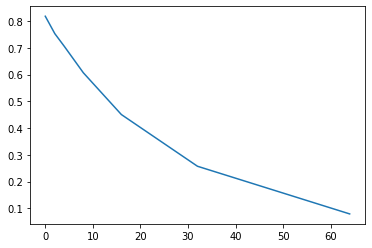

In [100]:
plt.plot(depths,results)

In [3040]:
circ.draw()

/usr/lib/python3.10/site-packages/IPython/core/displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


global phase: 3π/2
     ┌──────────┐┌────┐      ░ ┌──────────┐            ░ ┌──────────┐      »
q_0: ┤ Rz(-π/2) ├┤ √X ├──■───░─┤ Rz(-π/2) ├────────■───░─┤ Rz(-π/2) ├──────»
     ├─────────┬┘├────┤┌─┴─┐ ░ ├──────────┤┌────┐┌─┴─┐ ░ ├─────────┬┘┌────┐»
q_1: ┤ Rz(π/2) ├─┤ √X ├┤ X ├─░─┤ Rz(-π/2) ├┤ √X ├┤ X ├─░─┤ Rz(π/2) ├─┤ √X ├»
     └─────────┘ └────┘└───┘ ░ └──────────┘└────┘└───┘ ░ └─────────┘ └────┘»
«           ░ ┌─────────┐ ┌───┐       ░    ┌───┐    ┌─────────┐               »
«q_0: ──■───░─┤ Rz(π/2) ├─┤ X ├───■───░────┤ X ├────┤ Rz(π/2) ├────────────■──»
«     ┌─┴─┐ ░ ├─────────┴┐├───┴┐┌─┴─┐ ░ ┌──┴───┴───┐└──┬────┬─┘┌────────┐┌─┴─┐»
«q_1: ┤ X ├─░─┤ Rz(-π/2) ├┤ √X ├┤ X ├─░─┤ Rz(-π/2) ├───┤ √X ├──┤ Rz(-π) ├┤ X ├»
«     └───┘ ░ └──────────┘└────┘└───┘ ░ └──────────┘   └────┘  └────────┘└───┘»
«      ░ ┌─────────┐ ┌───┐                 ░ ┌──────────┐┌────┐┌─────────┐
«q_0: ─░─┤ Rz(π/2) ├─┤ X ├─────────────■───░─┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/2) ├
«      ░ ├─────────┴┐├───┴┐┌────────┐┌─┴─┐ ░ └┬────────┬┘└────┘└─────────┘
«q_1: ─░─┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π) ├┤ X ├─░──┤ Rz(-π) ├──────────────────
«      ░ └──────────┘└────┘└────────┘└───┘ ░  └────────┘

In [3041]:
circ.measure_all()
sim = Aer.get_backend('qasm_simulator')
sim.run(circ).result().get_counts()

{'00': 1024}

In [3042]:
metadata

{'prep_basis': Pauli('YY'),
 'meas_basis': Pauli('YY'),
 'length': 6,
 'rostring': 'II'}